# Common Risk Factors in Cryptocurrency

# Master Thesis Project

<div style="text-align: right;font-size: 0.8em">Document Version 1.0.0</div>

This file requires `pandas`, `datetime`, `numpy`, and `math` to run. If one of these imports fails, please install the corresponding library and make sure that you have activated the corresponding virtual environment.

The project follows closely the methodology proposed by Liu, Tsyvinski, and Wu (2022) in their paper titled [Common Risk Factors in Cryptocurrency](https://onlinelibrary.wiley.com/doi/abs/10.1111/jofi.13119). Researchers and practitioners can use this paper to check the results of the paper and perhaps retrieve an updated version of the basic findings. They can also use it as a toolbox to use for other projects or to run an extended analysis including further risk factors. Finally, asset management firm may use this code to assess the risk of their portfolio or to firm anomalies in the returns of cryptocurrencies.

For this analysis, I occasionally had to make assumption, for example, regarding the procedure to convert daily to weekly data. This is especially so because the authors of the paper did not provide a detailed enough description of their decisions. There are other, perhabs better ways of doing certain steps and I am always grateful for any feedback that you might provide.

The order of the following sections is closely following the structure of the paper. The outline is:
* [I. Data](#I.-Data): The files for all data sources can be found in the data folder. The main blockchain trading data is retrieved from CoinGecko (coingecko_data.py). It is advisable to download the cryptocurrency data set in smaller chunks (for example, 100 cryptocurrencies), since the data set is relatively large and takes long to download due to the API limit. The merge_data.py file can then be used to merge all individal cryptocurrency data files into one large file that is supposed to be loaded into the code below. The daily crptocurrency (aka coin) data is converted to weekly returns using the last available prices: $$r_t = \frac{p_t-p_{t-1}}{p_{t-1}}$$ One can also compute log-returns instead. The definition of the weeks is as follows: The first 7 days of a given year are the first week. The following 50 weeks consist of 7 days each. The last week has either 8 or 9 days (if the year is a leap year). 

# I. Data

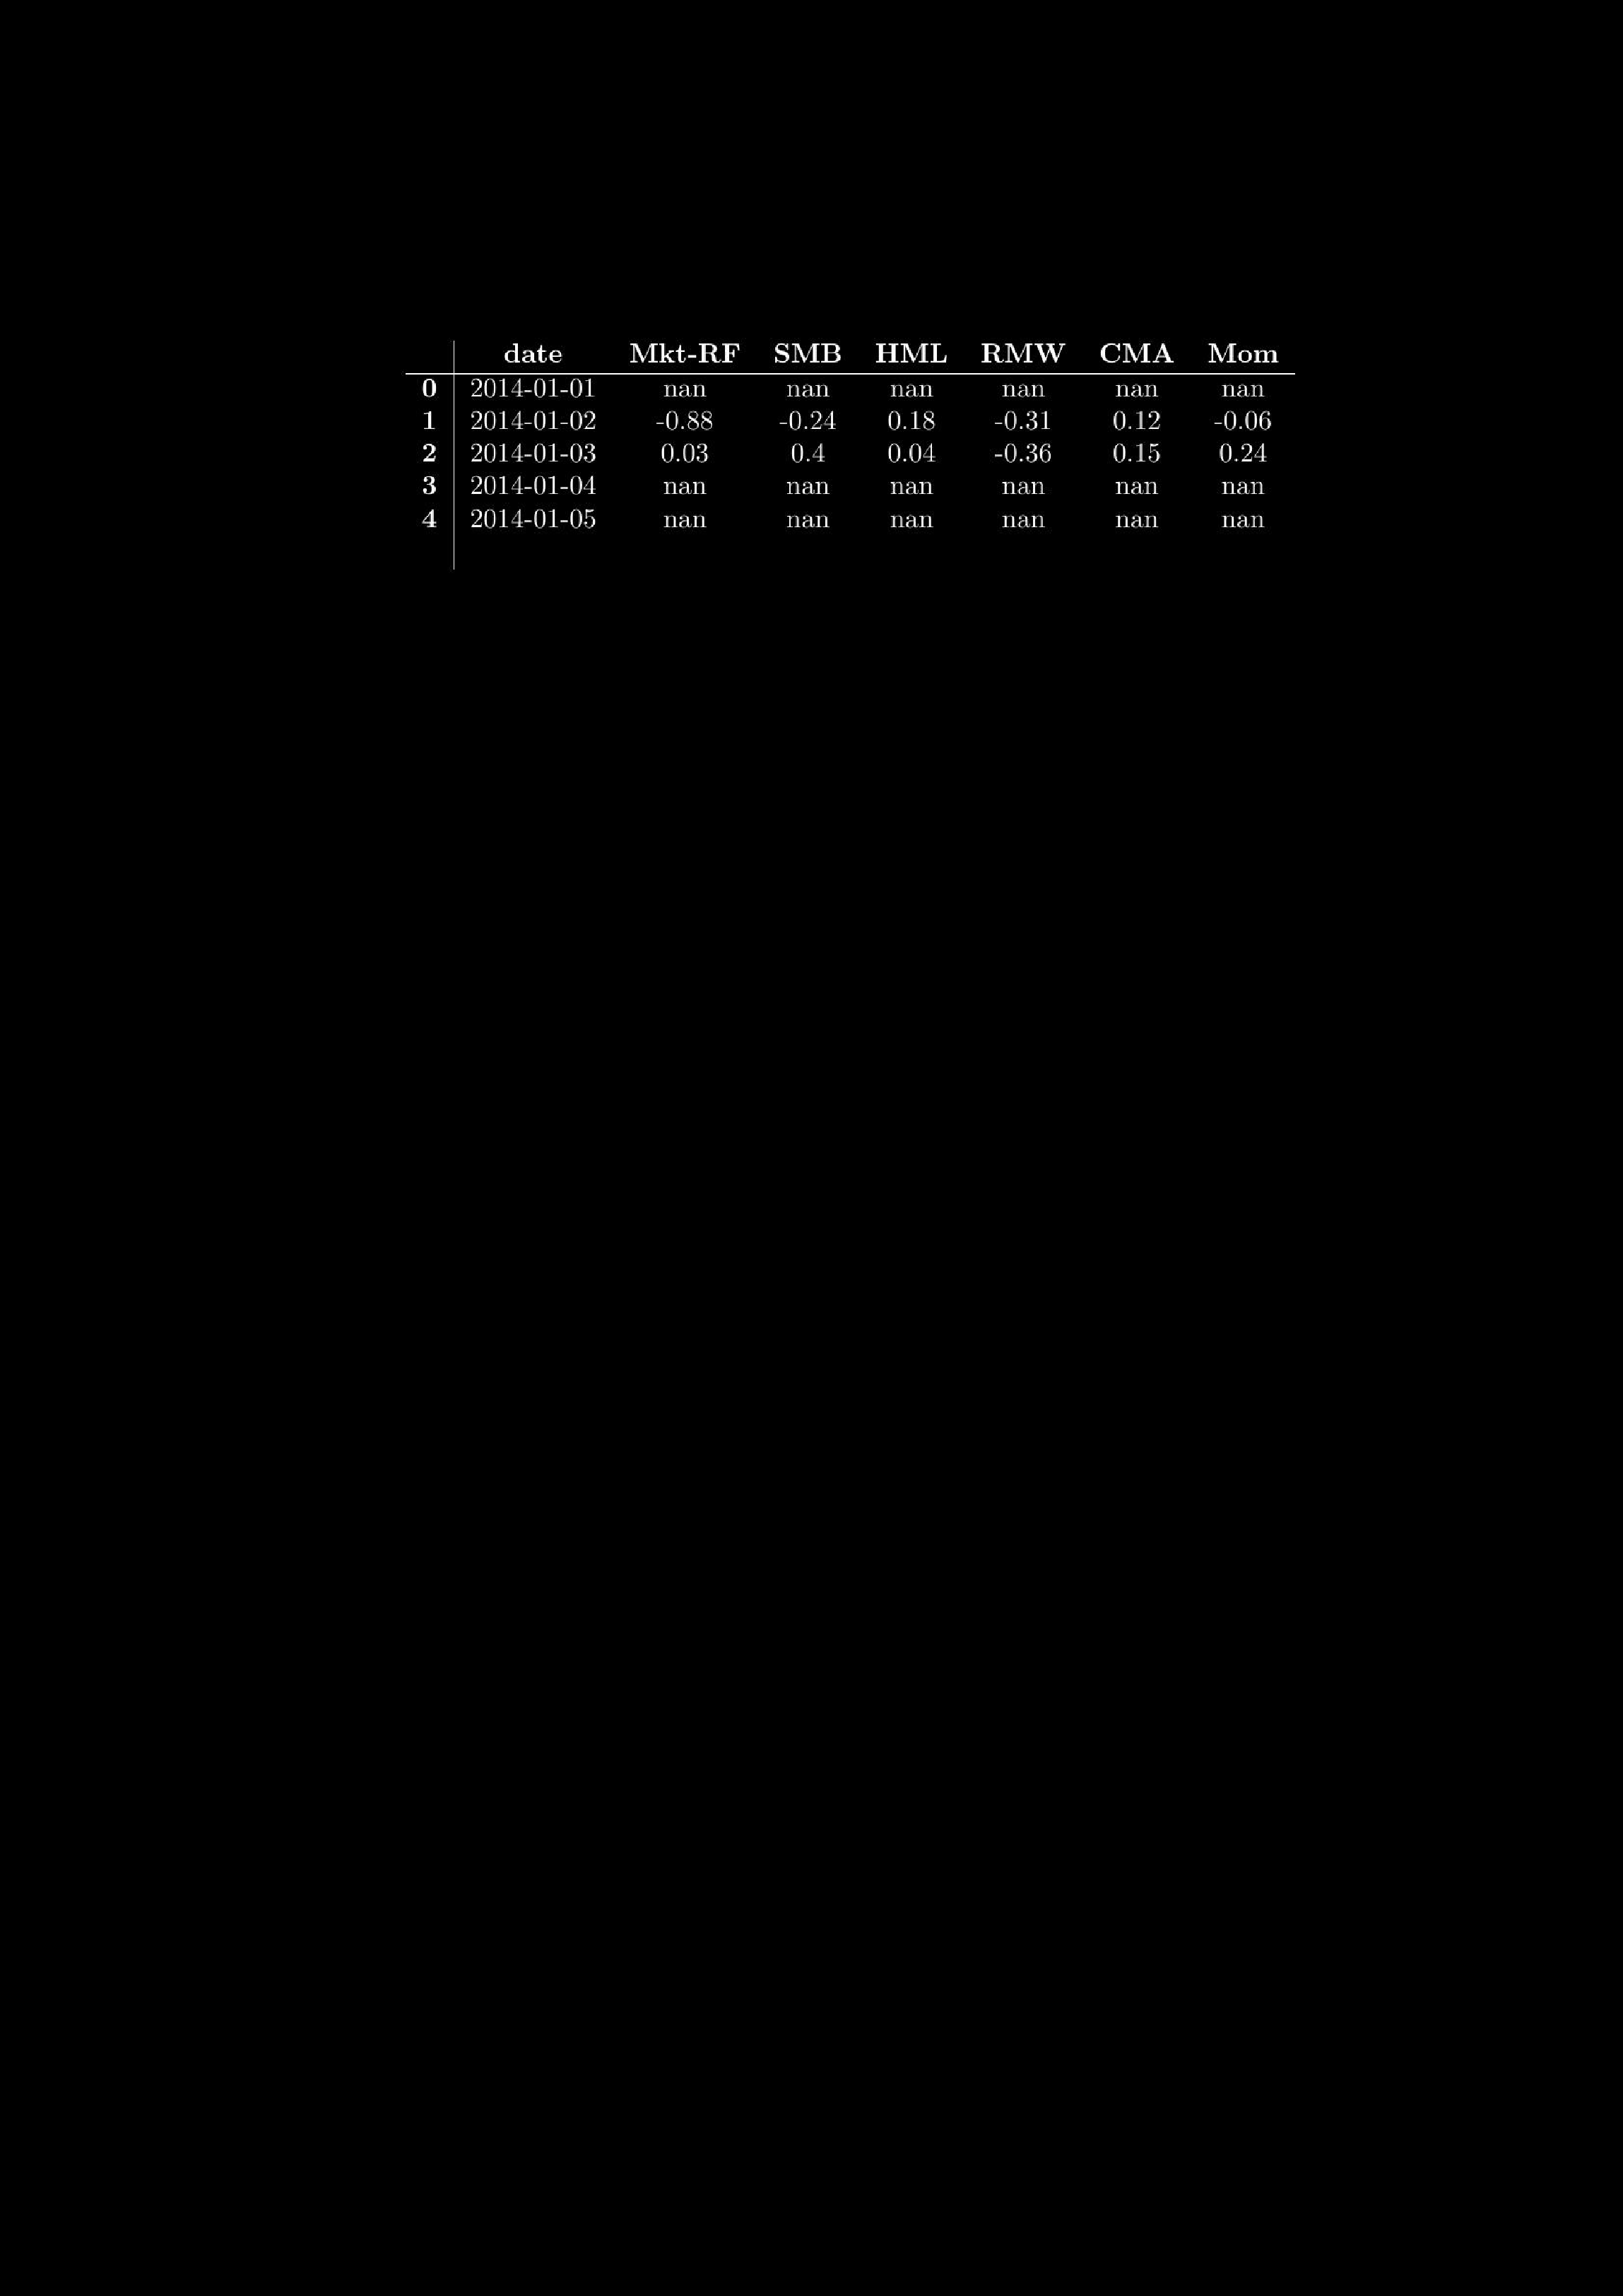

In [1]:
import pandas as pd, datetime, convert_frequency as cf, numpy as np, math, time, os, render_df

# specify the data range for the analysis
# in the paper, the authors start on 2014-01-01 due to data availability
start_date = "2014-01-01"
end_date = str(datetime.date.today())

# the path where you have stored the cryptocurrency trading data
data_path = r"/Users/Marc/Desktop/Past Affairs/Past Universities/SSE Courses/Master Thesis/Data"
# daily price, market cap, and trading volume data

daily_trading_data = pd.read_csv(data_path + "/coingecko/cg_data.csv")

# constructing weekly coin returns
# all unique coin IDs
coin_ids = pd.unique(daily_trading_data["id"])
# storing the data in a list with tuples for the ID and the weekly prices (last available prices each week)
coins_weekly_prices = {}
for coin_id in coin_ids:
    # get all the data for one coin
    coin_daily_trading_data = daily_trading_data[daily_trading_data["id"] == coin_id]
    # we need market_cap to compute the value-weighted market returns
    coin_daily_prices = coin_daily_trading_data[["date", "price", "market_cap"]]
    # now we compute the weekly prices
    # the first column is year/week and the second column is the weekly price
    coin_weekly_prices = cf.weekly_data(coin_daily_prices)
    coins_weekly_prices[coin_id] = coin_weekly_prices

# using the weekly price data to compute the weekly returns
coins_weekly_returns = {}
for coin_id in coin_ids:
    coin_weekly_prices = coins_weekly_prices[coin_id]
    # we are losing the first week, since we do not have a previous week for the first week (first week of 2014)
    coin_weekly_returns = [np.nan]
    for i in range(len(coin_weekly_prices) - 1):
        weekly_return = (coin_weekly_prices["price"][i + 1] - coin_weekly_prices["price"][i]) / coin_weekly_prices["price"][i]
        # alternatively, the log-return can be computed as follows (math.log() is the natural logarithm by default):
        # weekly_log_return = math.log(coin_weekly_prices["price"][i + 1] / coin_weekly_prices["price"][i])
        coin_weekly_returns.append(weekly_return)
    # adding the return column to the previous date column
    df = coin_weekly_prices["year/week", "market_cap"]
    df["return"] = coin_weekly_returns
    coins_weekly_returns[coin_id] = df
    # checking for NaNs
    if df["return"].isna().sum() != 0:
        print("The number of NaNs entries for " + coin_id + " is: " + str(df["return"].isna().sum()))

# constructing the cryptocurrency market returns
weeks = []
market_returns = []
included_ids = []
# looping through all weeks
for week in coins_weekly_returns[coin_ids[0]]["year/week"]:
    weeks.append(week)
    returns = []
    market_caps = []
    # to keep track of which and how many coins are included for every week
    weekly_included_ids = []
    for coin_id in coin_ids:
        coin_weekly_returns = coins_weekly_returns[coin_id]
        coin_weekly_data = coin_weekly_returns[coin_weekly_returns["year/week"] == week]
        # ignoring all NaNs
        # the most convenient way to check if no cell value are NaN is by applying .isna().sum().sum()
        if coin_weekly_data.isna().sum().sum() == 0:
            # the ID is included
            weekly_included_ids.append(coin_id)
            returns.append(coin_weekly_data["return"])
            market_caps.append(coin_weekly_data["market_cap"])
    # if all returns are NaN (for example, in the first week of the time period considered)
    if len(returns) == 0:
        # no value is added
        market_returns.append(np.nan)
        included_ids.append(np.nan)
    else:
        # for every week add the value-weighted market return (the sumproduct of the returns and the market caps divided by the sum of the market caps) and the included coin IDs
        market_returns.append(sum(x * y for x, y in zip(returns, market_caps)) / sum(market_caps))
        included_ids.append(weekly_included_ids)
market_returns = pd.DataFrame({"week": weeks, "average_return": market_returns, "included_ids": included_ids})





# creates a temporary PDF file named "cover.pdf"
# repeating the process overwrites the file
render_df.pdf_from_df(df)

time.sleep(3)
# the path where the PDF is stored
path = os.getcwd() + "/cover.pdf"

if input("Is your editor is dark mode? y/n") in ["Y", "y"]:

    from pdf2image import convert_from_path
    from PIL import ImageChops

    pil_image_lst = convert_from_path(path)
    image = pil_image_lst[0]
    image = ImageChops.invert(image)
    image.save(path)
    time.sleep(3)

from wand.image import Image as WImage
img = WImage(filename=path, resolution=100)
img

